# Market prediction with LSTM

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

print(torch.__version__)
print(torch.cuda.is_available())  # Para verificar si CUDA está activado

# Configuración de dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo de entrenamiento: {device}")

2.5.1
True
Dispositivo de entrenamiento: cuda


## Defining LSTM model

In [2]:
class ImprovedLSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=5, num_features=4):
        super(ImprovedLSTMPredictor, self).__init__()
        
        # Configuración de capas LSTM
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=0.3,  
            bidirectional=True  # LSTM bidireccional
        )
        
        # Normalización de capa
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        
        # Capas de dropout
        self.dropout = nn.Dropout(0.4)
        
        # Capas fully connected con regularización
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_features)
        )
    
    def forward(self, x):
        # Paso por capa LSTM
        lstm_out, _ = self.lstm(x)
        
        # Concatenar última salida de ambas direcciones
        out = lstm_out[:, -1, :]
        
        # Normalización de capa
        out = self.layer_norm(out)
        
        # Dropout
        out = self.dropout(out)
        
        # Capas fully connected
        out = self.fc_layers(out)
        
        return out

## Market prediction main class

In [3]:
class MarketPredictor:
    def __init__(self, file_path, time_steps=10):
        # Cargar datos con el separador correcto (punto y coma)
        df = pd.read_csv(file_path, sep=';')
        
        print(f"Archivo cargado exitosamente. Forma: {df.shape}")
        print(f"Columnas: {df.columns.tolist()}")
        
        # Procesar timestamps
        df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
        
        # Características para predicción
        self.features = ['Open', 'High', 'Low', 'Close']
        
        # Agrupar datos por intervalos de 10 minutos
        df['10min_group'] = df['Timestamp'].dt.floor('10T')
        grouped = df.groupby('10min_group')[self.features].agg({
            'Open': 'first', 
            'High': 'max', 
            'Low': 'min', 
            'Close': 'last'
        }).reset_index()
        
        # Convertir los valores de string a float
        for feature in self.features:
            if grouped[feature].dtype == 'object':
                grouped[feature] = grouped[feature].str.replace(',', '.').astype(float)
        
        # Preparar datos
        data = grouped[self.features].values
        
        # Normalizar datos
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaled_data = self.scaler.fit_transform(data)
        
        # Configuraciones del modelo
        self.time_steps = time_steps
        self.model = None
        self.last_timestamp = grouped['10min_group'].max()
        self.grouped_data = grouped
        
        # Dispositivo de entrenamiento
        self.device = device
    
    def create_sequences(self, data):
        """Crear secuencias para LSTM"""
        X, y = [], []
        for i in range(len(data) - self.time_steps):
            X.append(data[i:i+self.time_steps])
            y.append(data[i+self.time_steps])
        return np.array(X), np.array(y)
    
    def prepare_data(self):
        """Preparar datos de entrenamiento"""
        # Crear secuencias
        X, y = self.create_sequences(self.scaled_data)
        
        # Dividir datos
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        
        # Convertir a tensores
        self.X_train = torch.FloatTensor(X_train).to(self.device)
        self.y_train = torch.FloatTensor(y_train).to(self.device)
        self.X_val = torch.FloatTensor(X_val).to(self.device)
        self.y_val = torch.FloatTensor(y_val).to(self.device)
        self.X_test = torch.FloatTensor(X_test).to(self.device)
        self.y_test = torch.FloatTensor(y_test).to(self.device)
        
        return X_train.shape[1], X_train.shape[2]
    
    def build_model(self, input_shape):
        """Construir modelo LSTM"""
        self.model = ImprovedLSTMPredictor(
            input_size=input_shape[1],
            hidden_size=64,
            num_layers=3,
            num_features=4
        ).to(self.device)
        
        # Configurar pérdida y optimizador
        self.criterion = nn.MSELoss()
        self.optimizer = optim.AdamW(
            self.model.parameters(), 
            lr=0.0005,
            weight_decay=1e-4
        )
        
        # Scheduler de learning rate
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='min', 
            factor=0.5, 
            patience=5, 
            verbose=True
        )
    
    def train_model(self, epochs=100):
        """Entrenar modelo con early stopping"""
        # Preparar datos y modelo
        input_shape = self.prepare_data()
        self.build_model(input_shape)
        
        # Variables para early stopping
        best_val_loss = float('inf')
        patience = 10
        trigger_times = 0
        
        # Almacenar pérdidas
        train_losses, val_losses = [], []
        
        # Bucle de entrenamiento
        for epoch in range(epochs):
            # Modo de entrenamiento
            self.model.train()
            
            # Paso hacia adelante
            outputs = self.model(self.X_train)
            loss = self.criterion(outputs, self.y_train)
            
            # Retropropagación
            self.optimizer.zero_grad()
            loss.backward()
            
            # Clip de gradientes
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1)
            
            self.optimizer.step()
            
            # Validación
            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(self.X_val)
                val_loss = self.criterion(val_outputs, self.y_val)
            
            # Actualizar scheduler
            self.scheduler.step(val_loss)
            
            # Almacenar pérdidas
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                trigger_times = 0
                torch.save(self.model.state_dict(), 'best_model.pth')
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f"Early stopping en época {epoch}")
                    break
            
            # Imprimir progreso
            if (epoch + 1) % 5 == 0:
                print(f'Época [{epoch+1}/{epochs}], '
                      f'Pérdida de Entrenamiento: {loss.item():.4f}, '
                      f'Pérdida de Validación: {val_loss.item():.4f}')
        
        # Cargar mejor modelo
        self.model.load_state_dict(torch.load('best_model.pth'))
        
        # Graficar pérdidas
        plt.figure(figsize=(10,5))
        plt.plot(train_losses, label='Pérdida de Entrenamiento')
        plt.plot(val_losses, label='Pérdida de Validación')
        plt.title('Curva de Pérdida')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
        plt.legend()
        plt.show()
        
        return train_losses, val_losses
    
    def predict_next_day(self):
        """Predecir próximos intervalos"""
        if self.model is None:
            raise ValueError("Primero debes entrenar el modelo")
        
        # Preparar última secuencia
        last_sequence = self.scaled_data[-self.time_steps:]
        
        # Almacenar predicciones
        predictions = []
        prediction_timestamps = []
        
        # Modo de evaluación
        self.model.eval()
        
        # Predecir próximos 6 intervalos
        with torch.no_grad():
            for i in range(20):
                # Preparar tensor de entrada
                input_tensor = torch.FloatTensor(last_sequence).unsqueeze(0).to(self.device)
                
                # Hacer predicción
                next_pred = self.model(input_tensor).cpu().numpy()[0]
                
                # Almacenar predicción
                predictions.append(next_pred)
                
                # Generar timestamp
                next_timestamp = self.last_timestamp + pd.Timedelta(minutes=10*(i+1))
                prediction_timestamps.append(next_timestamp)
                
                # Actualizar secuencia
                last_sequence = np.roll(last_sequence, -1, axis=0)
                last_sequence[-1] = next_pred
        
        # Revertir normalización
        predictions = self.scaler.inverse_transform(np.array(predictions))
        
        # Crear DataFrame con predicciones
        pred_df = pd.DataFrame(predictions, columns=self.features)
        pred_df['Timestamp'] = prediction_timestamps
        
        return pred_df
    
    def visualize_predictions(self, predictions):
        """Visualizar predicciones"""
        plt.figure(figsize=(15,10))
        for i, feature in enumerate(self.features):
            plt.subplot(2,2,i+1)
            plt.plot(predictions['Timestamp'], predictions[feature], marker='o')
            plt.title(f'Predicción de {feature}')
            plt.xticks(rotation=45)
            plt.xlabel('Timestamp')
            plt.ylabel(feature)
        plt.tight_layout()
        plt.show()
    
    def compare_last_data(self, predictions):
        """Comparar predicciones con últimos datos"""
        # Mostrar últimos datos reales
        print("\nÚltimos datos reales:")
        print(self.grouped_data.tail())
        
        print("\nPredicciones:")
        print(predictions)
        
        # Calcular diferencias porcentuales
        last_real = self.grouped_data[self.features].iloc[-1]
        first_pred = predictions[self.features].iloc[0]
        
        print("\nComparación y variación:")
        for feature in self.features:
            diff = first_pred[feature] - last_real[feature]
            pct_change = (diff / last_real[feature]) * 100
            print(f"{feature}: Último Real = {last_real[feature]:.2f}, "
                  f"Primera Predicción = {first_pred[feature]:.2f}, "
                  f"Variación = {pct_change:.2f}%")

## Execution

Archivo cargado exitosamente. Forma: (75492, 25)
Columnas: ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Up', 'Down', 'TEMA', 'MAA', 'GannHiLo', 'UpperBand', 'LowerBand', 'MidLine', 'AvgExp', 'MAA_1', 'KinglerOsc', 'SignalLine', 'RSI', 'OverBot', 'OverSld', 'MACD', 'MACDAvg', 'MACDDiff', 'ZeroLine']


C:\Users\pc\AppData\Local\Temp\ipykernel_6568\1702445530.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
C:\Users\pc\AppData\Local\Temp\ipykernel_6568\1702445530.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['10min_group'] = df['Timestamp'].dt.floor('10T')
c:\Users\pc\anaconda3\envs\mp\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Época [5/100], Pérdida de Entrenamiento: 0.3433, Pérdida de Validación: 0.3105
Época [10/100], Pérdida de Entrenamiento: 0.2663, Pérdida de Validación: 0.2722
Época [15/100], Pérdida de Entrenamiento: 0.2062, Pérdida de Validación: 0.1913
Época [20/100], Pérdida de Entrenamiento: 0.1678, Pérdida de Validación: 0.1535
Época [25/100], Pérdida de Entrenamiento: 0.1369, Pérdida de Validación: 0.1221
Época [30/100], Pérdida de Entrenamiento: 0.1119, Pérdida de Validación: 0.1194
Época [35/100], Pérdida de Entrenamiento: 0.0910, Pérdida de Validación: 0.1020
Época [40/100], Pérdida de Entrenamiento: 0.0733, Pérdida de Validación: 0.0686
Época [45/100], Pérdida de Entrenamiento: 0.0588, Pérdida de Validación: 0.0600
Época [50/100], Pérdida de Entrenamiento: 0.0478, Pérdida de Validación: 0.0529
Época [55/100], Pérdida de Entrenamiento: 0.0387, Pérdida de Validación: 0.0413
Época [60/100], Pérdida de Entrenamiento: 0.0317, Pérdida de Validación: 0.0360
Época [65/100], Pérdida de Entrenamiento:

C:\Users\pc\AppData\Local\Temp\ipykernel_6568\1702445530.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('best_model.pth'))


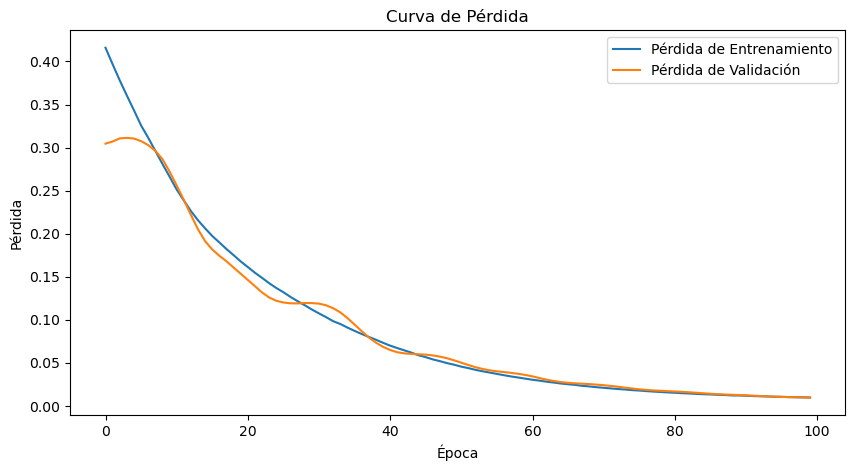

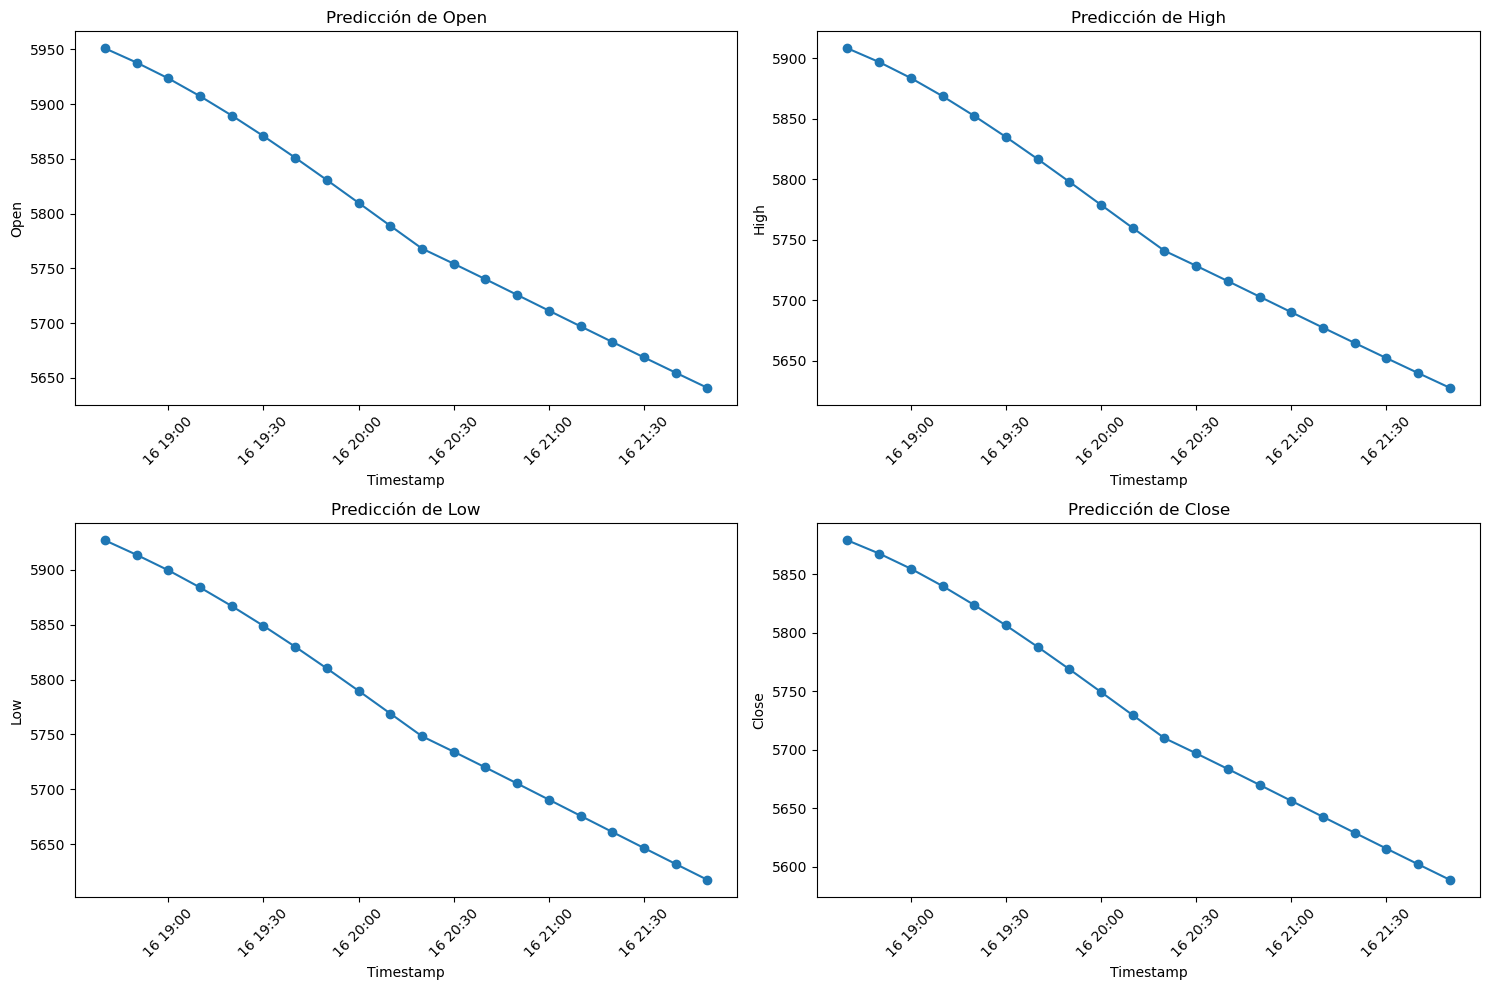

In [4]:
def main():
    # Ruta del archivo de datos
    file_path = '../data/two-years-data.csv'
    
    # Crear predictor
    predictor = MarketPredictor(file_path)
    
    # Entrenar modelo
    train_losses, val_losses = predictor.train_model()
    
    # Predecir próximo intervalo
    predictions = predictor.predict_next_day()
    
    # Comparar con últ e_last_data(predictions)
    
    # Visualizar predicciones
    predictor.visualize_predictions(predictions)
    
    return predictions

# Ejecutar script principal
if __name__ == '__main__':
    predictions = main()